In [1]:
# import os
# import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# os.environ["KERAS_BACKEND"] = "torch"
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras import backend as K

# os.environ["KERAS_BACKEND"] = "torch"
print("Keras backend:", K.backend())
# print(torch.version.cuda)

# print(torch.cuda.is_available())  # Should return True
# print(torch.cuda.current_device())  # Device ID
# print(torch.cuda.get_device_name(0))

Keras backend: tensorflow


In [65]:
# Generate or load time series data
# np.random.seed(0)
# data = np.sin(np.linspace(0, 100, 20000)) + 0.1 * np.random.normal(size=20000)

train_df = pd.read_csv("train.csv", parse_dates=["Datetime"], dayfirst=True)
data = train_df["Count"].values

# train_df = pd.read_csv("NVidia_stock_history.csv", parse_dates=["Date"], dayfirst=True)
# data = train_df["Volume"].values

print(train_df.head)


<bound method NDFrame.head of           ID            Datetime  Count
0          0 2012-08-25 00:00:00      8
1          1 2012-08-25 01:00:00      2
2          2 2012-08-25 02:00:00      6
3          3 2012-08-25 03:00:00      2
4          4 2012-08-25 04:00:00      2
...      ...                 ...    ...
18283  18283 2014-09-25 19:00:00    868
18284  18284 2014-09-25 20:00:00    732
18285  18285 2014-09-25 21:00:00    702
18286  18286 2014-09-25 22:00:00    580
18287  18287 2014-09-25 23:00:00    534

[18288 rows x 3 columns]>


In [66]:

data = data.reshape(-1, 1)

# Preprocessing: Normalize data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Prepare data for LSTM
sequence_length = 75
X, y = [], []
for i in range(len(data) - sequence_length):
    X.append(data[i : i + sequence_length])
    y.append(data[i + sequence_length])
X, y = np.array(X), np.array(y)

# Split into train and test
split = int(0.95 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [67]:
# Build the LSTM model


model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.1))

# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')



C:\Users\maria\anaconda3\envs\cuda\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
# Train the model
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)


learningRateScheduler = LearningRateScheduler(scheduler, verbose=0)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[learningRateScheduler])

# Predict on test data
predictions = model.predict(X_test)


Epoch 1/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 0.0051 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 2/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 0.0014 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.0011 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 4/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 9.3619e-04 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 5/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 9.6277e-04 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 6/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 8.9259e-04 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 7/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 8.5026e-04 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 8/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 8.3323e-04 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 9/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - loss: 7.9709e-04 - val_loss:

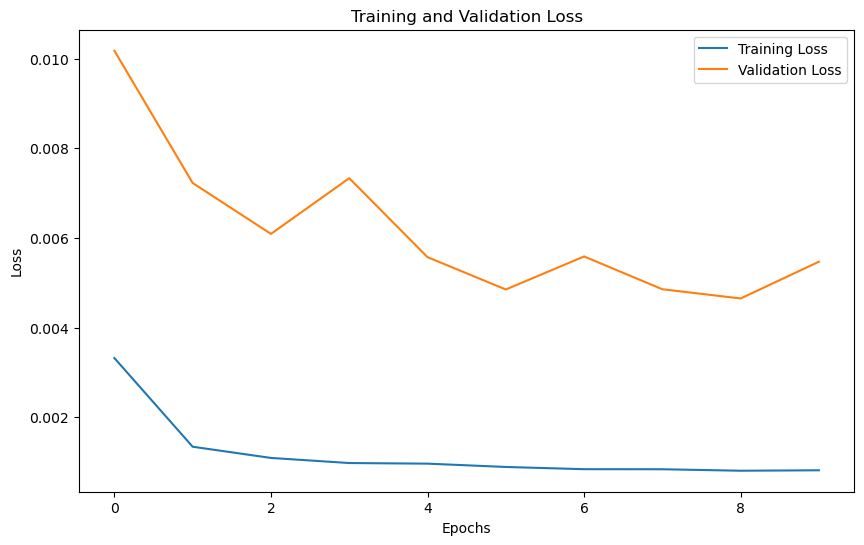

In [69]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [70]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


541/541 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [31]:
y_test = scaler.inverse_transform(y_test)
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

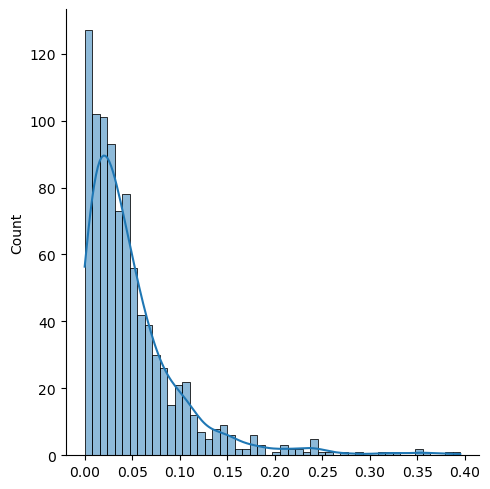

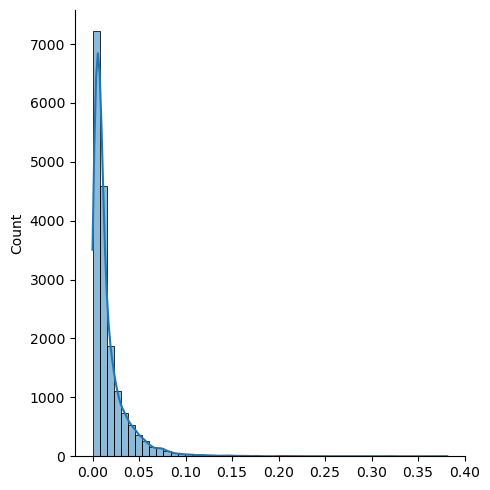

In [71]:
test_mae_loss = np.mean(np.abs(test_predictions - y_test), axis=1)
sns.displot(test_mae_loss, bins=50, kde=True)

train_mae_loss = np.mean(np.abs(train_predictions - y_train), axis=1)
sns.displot(train_mae_loss, bins=50, kde=True)

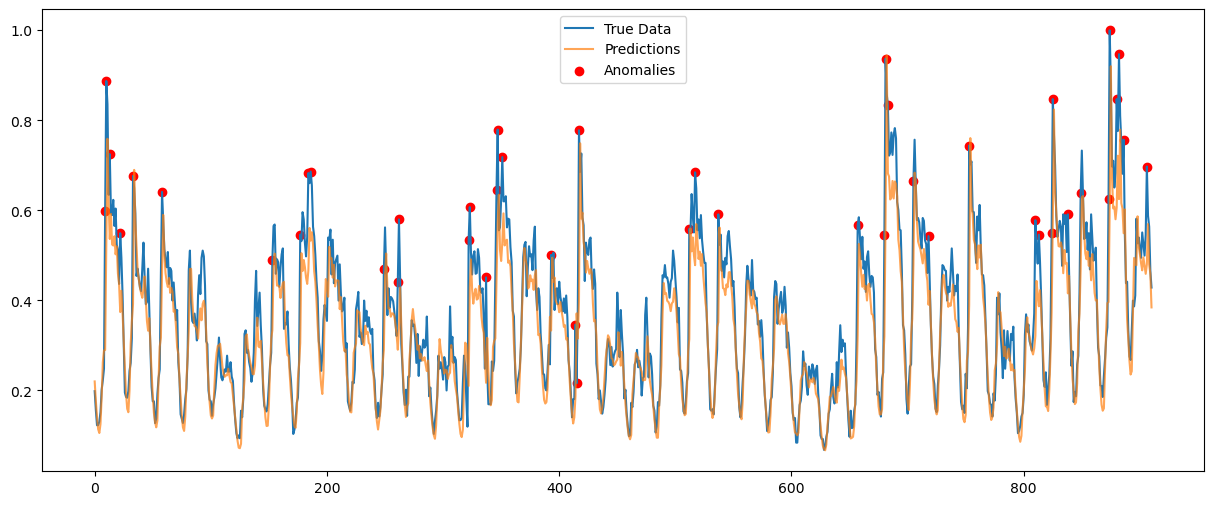

In [75]:
# Calculate loss
loss = np.mean(np.abs(test_predictions - y_test), axis=1)

threshold = 0.15
anomalies = loss > threshold

# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test)), y_test, label='True Data')
plt.plot(range(len(predictions)), test_predictions, label='Predictions', alpha=0.7)
plt.scatter(np.where(anomalies)[0], y_test[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()